# Practing K-Mean clustering (2012 to 2021 so fare!)
## Goal: Try to put the all the musicians into clusters. Singer/songwriter, Featuring Artist, songwriter etc.
## Expectations: Very big cluster with the 'average' artists/writers. Smallish Cluster with Big stars.  And one very small cluster with super star!
Might introduce another feature called number of top 10 songs or something like that. Genres maybe

In [1]:
import pandas as pd
df = pd.read_csv('data/artist_2012_2021_test.csv')
df


,Name,Main Artist,Featuring Artist,Writer
0,2 Chainz,2,2,0
1,21 Savage,2,4,0
2,24kGoldn,2,0,0
3,42 Dugg,0,1,0
4,5 Seconds of Summer,4,0,0
...,...,...,...,...
1218,Zedd,4,1,0
1219,busbee,0,0,2
1220,iLoveMemphis,1,0,0
1221,soFLY & Nius,0,0,1


### 1. Exploring the Dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              1223 non-null   object
 1   Main Artist       1223 non-null   int64 
 2   Featuring Artist  1223 non-null   int64 
 3   Writer            1223 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 38.3+ KB


In [44]:
df.describe()

,Main Artist,Featuring Artist,Writer
count,1223.000000,1223.000000,1223.000000
mean,0.821750,0.309894,1.636958
std,2.113618,1.131874,2.713669
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,1.000000,0.000000,2.000000
max,29.000000,21.000000,49.000000


In [4]:
from sklearn.preprocessing import StandardScaler as SS # z-score standardization 
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

In [5]:
#pip install yellowbrick

In [6]:
def silhouettePlot(range_, data):
    '''
    we will use this function to plot a silhouette plot that helps us to evaluate the cohesion in clusters (k-means only)
    '''
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    #fig.savefig("silhouette_plot.png")

In [7]:
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    #fig.savefig("elbow_plot.png")


In [8]:
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [9]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    '''
    very basic implementation of an algorithm for feature selection (unsupervised clustering); inspired by this post: https://datascience.stackexchange.com/questions/67040/how-to-do-feature-selection-for-clustering-and-implement-it-in-python
    '''
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

### Standardized

In [10]:
scaler = SS()
DNP_artists_standardized = scaler.fit_transform(df.drop("Name",axis=1))
df_artists_standardized = pd.DataFrame(DNP_artists_standardized, columns=["main_artist_standardized","featuring_artist_standardized","songwriter_standardized"])
df_artists_standardized = df_artists_standardized.set_index(df.index)

In [11]:
df_artists_standardized

,main_artist_standardized,featuring_artist_standardized,songwriter_standardized
0,0.557685,1.493804,-0.603474
1,0.557685,3.261509,-0.603474
2,0.557685,-0.273900,-0.603474
3,-0.388947,0.609952,-0.603474
4,1.504316,-0.273900,-0.603474
...,...,...,...
1218,1.504316,0.609952,-0.603474
1219,-0.388947,-0.273900,0.133837
1220,0.084369,-0.273900,-0.603474
1221,-0.388947,-0.273900,-0.234818


### Find the best 3(or more) features. OBS.: Right now i only have 3. So there is no point in doing it..

In [12]:
selected_features = progressiveFeatureSelection(df_artists_standardized, max_features=3, n_clusters=3)

Proposed new feature main_artist_standardized with score 0.8352401490987581
Proposed new feature featuring_artist_standardized with score 0.8974688746688784
Proposed new feature songwriter_standardized with score 0.8114926026742859
The initial feature is featuring_artist_standardized with a silhouette score of 0.8974688746688784.
Starting selection 0...
Proposed new feature main_artist_standardized with score 0.8116763719019036
Proposed new feature songwriter_standardized with score 0.7237731416210214
Selected new feature main_artist_standardized with score 0.8116763719019036
Starting selection 1...
Proposed new feature songwriter_standardized with score 0.7735701718972212
Selected new feature songwriter_standardized with score 0.7735701718972212


In [13]:
# slice it into a new dataframe
df_standardized_sliced = df_artists_standardized[selected_features]

## Choosing the Right Amount of Clusters

/tmp/ipykernel_64/817249690.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


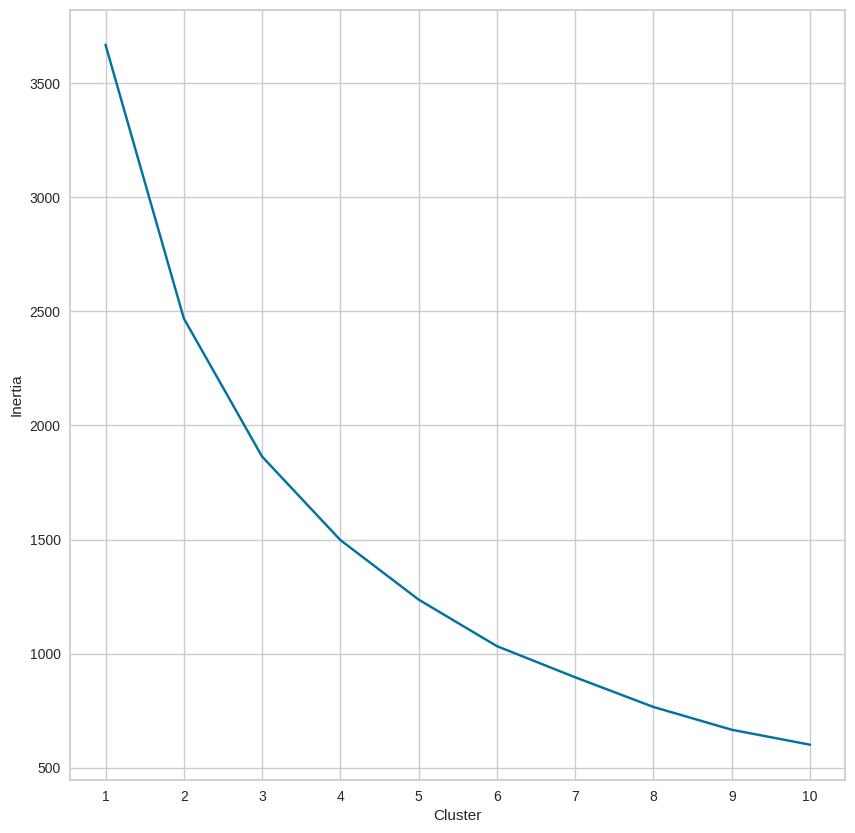

In [14]:
elbowPlot(range(1,11), df_standardized_sliced)

- The elbow is bending at about x clusters.

/tmp/ipykernel_64/2866924435.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


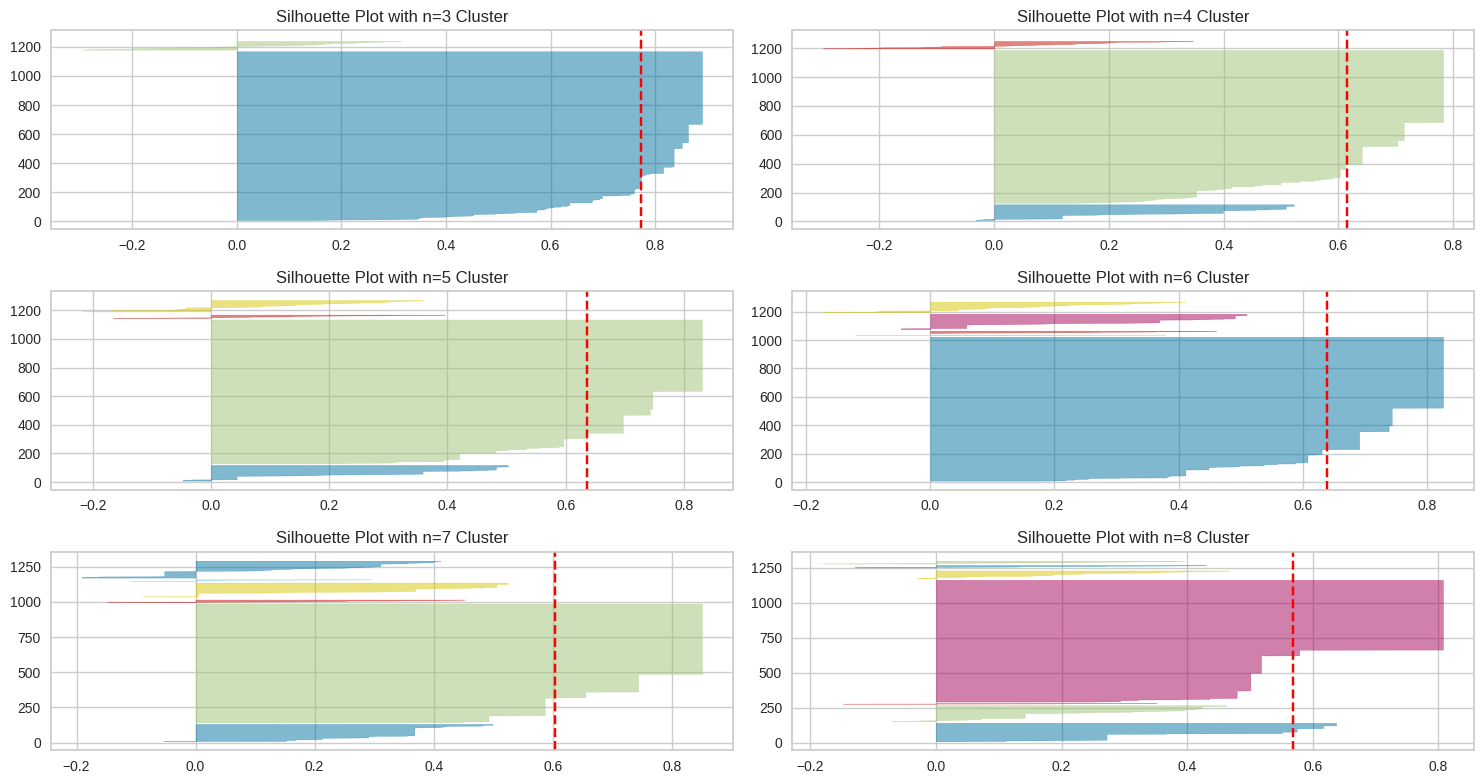

In [15]:
silhouettePlot(range(3,9), df_standardized_sliced)

- All have a silhouette score above 6. But 4 clusters still seems to have the highest. But i might go with 6, 7 or 8. Because of the way the 'knifes' looks.

/tmp/ipykernel_64/2870745032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_sliced["clusters"] = cluster_labels


<AxesSubplot: xlabel='pc_1', ylabel='pc_2'>

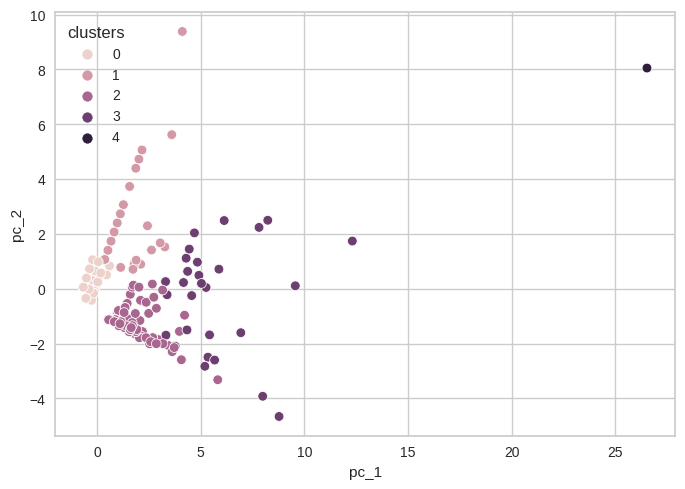

In [33]:
clusters = 5

# Not sure what the random_state is. "..the parameter allows us to reproduce our results..."
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)
df_standardized_sliced["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
authors_standardized_pca = pca.fit_transform(df_standardized_sliced)
df_authors_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns=["pc_1", "pc_2"])
df_authors_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_authors_standardized_pca)

In [34]:
df_authors_standardized_pca

,pc_1,pc_2,clusters
0,1.595179,-1.496027,2
1,2.583465,-1.934543,2
2,-0.270828,-0.421515,0
3,0.556996,-1.132262,2
4,1.150933,-1.202017,2
...,...,...,...
1218,1.645076,-1.421275,2
1219,-0.515790,0.388222,0
1220,-0.542848,-0.349262,0
1221,-0.665329,0.055606,0


In [35]:
cluster_df = df_standardized_sliced[["clusters"]]

In [36]:
df_clustered_data = pd.merge(df , cluster_df, left_index=True, right_index=True)
df_clustered_data

,Name,Main Artist,Featuring Artist,Writer,clusters
0,2 Chainz,2,2,0,2
1,21 Savage,2,4,0,2
2,24kGoldn,2,0,0,0
3,42 Dugg,0,1,0,2
4,5 Seconds of Summer,4,0,0,2
...,...,...,...,...,...
1218,Zedd,4,1,0,2
1219,busbee,0,0,2,0
1220,iLoveMemphis,1,0,0,0
1221,soFLY & Nius,0,0,1,0


In [37]:
#
df_clustered_data[df_clustered_data['clusters'] == 0]

,Name,Main Artist,Featuring Artist,Writer,clusters
2,24kGoldn,2,0,0,0
9,A Great Big World,1,0,0,0
10,A. P. Carter,0,0,1,0
11,AJR,1,0,0,0
12,ASAP Ferg,1,0,0,0
...,...,...,...,...,...
1216,Zay Hilfigerrr & Zayion McCall,1,0,0,0
1217,Zayn,2,0,3,0
1219,busbee,0,0,2,0
1220,iLoveMemphis,1,0,0,0


In [38]:
# Medium sized artists
df_clustered_data[df_clustered_data['clusters'] == 1]

,Name,Main Artist,Featuring Artist,Writer,clusters
25,Adam Levine,0,2,20,1
34,Ahmad Balshe,0,0,5,1
40,Alessia Cara,3,3,9,1
57,Amala Dlamini,0,0,5,1
77,Andrew Taggart,0,0,5,1
...,...,...,...,...,...
1100,Teddy Geiger,0,0,7,1
1162,Tyler Hubbard,0,0,7,1
1183,Wayne Sermon,0,0,5,1
1187,William Grigahcine,0,0,5,1


In [39]:
# 
df_clustered_data[df_clustered_data['clusters'] == 2]

,Name,Main Artist,Featuring Artist,Writer,clusters
0,2 Chainz,2,2,0,2
1,21 Savage,2,4,0,2
3,42 Dugg,0,1,0,2
4,5 Seconds of Summer,4,0,0,2
5,50 Cent,0,1,0,2
...,...,...,...,...,...
1205,Young Dolph,0,1,0,2
1206,Young Thug,2,7,0,2
1207,YoungBoy Never Broke Again,1,1,0,2
1218,Zedd,4,1,0,2


In [40]:
# 
df_clustered_data[df_clustered_data['clusters'] == 3]

,Name,Main Artist,Featuring Artist,Writer,clusters
31,Adele,9,0,9,3
92,Ariana Grande,20,4,11,3
142,Billie Eilish,7,0,6,3
186,Bruno Mars,7,4,10,3
198,Calvin Harris,10,1,8,3
201,Camila Cabello,4,5,8,3
204,Cardi B,10,4,1,3
224,Charlie Puth,5,4,8,3
233,Chris Brown,10,6,5,3
347,Dua Lipa,6,1,5,3


In [41]:
# 
df_clustered_data[df_clustered_data['clusters'] == 4]

,Name,Main Artist,Featuring Artist,Writer,clusters
345,Drake,29,21,49,4


In [42]:
df_clustered_data[df_clustered_data['clusters'] == 5]

,Name,Main Artist,Featuring Artist,Writer,clusters


In [43]:
#
df_clustered_data[df_clustered_data['clusters'] == 6]

,Name,Main Artist,Featuring Artist,Writer,clusters


# Other tutorial  (Not as good)
https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a

In [6]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 7.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:

import plotly.express as px
fig = px.scatter_matrix(df.drop("Name",axis=1),
width=950, height=1200)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [18]:
# Somethings wrong with this. color and size
fig1 = px.scatter(df, x="Main Artist", y="Featuring Artist", color="Writer",
                 size="Main Artist")
fig1.update_layout(title="4 Features Representation")
fig1.show()

### Find the optimal amount of clusters

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import numpy as np
X=df.drop("Name",axis=1)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
fig = go.Figure(data=go.Scatter(x=np.arange(1,11),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=3,
            y=inertia[2],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])

In [21]:
pie=clusters.groupby('label').size().reset_index()
pie.columns=['label','value']
px.pie(pie,values='value',names='label',color=['blue','red','green'])

#### Not the result i had expected. Need more research